# Notebook 13: Using Deep Learning to Study SUSY with Pytorch
Yi Ming Chang <br>
B00751897<br>
Mar. 7th, 2021

## Learning Goals
The goal of this notebook is to introduce the powerful PyTorch framework for building neural networks and use it to analyze the SUSY dataset. After this notebook, the reader should understand the mechanics of PyTorch and how to construct DNNs using this package. In addition, the reader is encouraged to explore the GPU backend available in Pytorch on this dataset.

## Overview
In this notebook, we use Deep Neural Networks to classify the supersymmetry dataset, first introduced by Baldi et al. in [Nature Communication (2015)](https://www.nature.com/articles/ncomms5308). The SUSY data set consists of 5,000,000 Monte-Carlo samples of supersymmetric and non-supersymmetric collisions with $18$ features. The signal process is the production of electrically-charged supersymmetric particles which decay to $W$ bosons and an electrically-neutral supersymmetric particle that is invisible to the detector.

The first $8$ features are "raw" kinematic features that can be directly measured from collisions. The final $10$ features are "hand constructed" features that have been chosen using physical knowledge and are known to be important in distinguishing supersymmetric and non-supersymmetric collision events. More specifically, they are given by the column names below.

In this notebook, we study this dataset using Pytorch.

# Without CUDA commands

In [1]:
from __future__ import print_function, division
import os,sys
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import torch # pytorch package, allows using GPUs
# fix seed
seed=17
np.random.seed(seed)


Last, we define a helper function `load_data()` that accepts as a required argument the set of parameters `args`, and returns two generators: `test_loader` and `train_loader` which readily return mini-batches.

In [2]:
def load_data(args):

    data_file='SUSY.csv'
    root_dir=os.path.expanduser('~')+'/ML_review/SUSY_data/'

    kwargs = {} # CUDA arguments, if enabled
    # load and noralise train and test data
    train_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=True,high_level_feats=args.high_level_feats),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=False,high_level_feats=args.high_level_feats),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader

### Step 2: Define the Neural Net and its Architecture

To construct neural networks with Pytorch, we make another class called `model` as a child of Pytorch's `nn.Module` class. The `model` class initializes the types of layers needed for the deep neural net in its `__init__` method, while the DNN is assembled in a function method called `forward`, which accepts an `autograd.Variable` object and returns the output layer. Using this convention Pytorch will automatically recognize the structure of the DNN, and the `autograd` module will pull the gradients forward and backward using backprop.

Our code below is constructed in such a way that one can choose whether to use the high-level and low-level features separately and altogether. This choice determines the size of the fully-connected input layer `fc1`. Therefore the `__init__` method accepts the optional argument `high_level_feats`. 

In [3]:
import torch.nn as nn # construct NN

class model(nn.Module):
    def __init__(self,high_level_feats=None):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()

        # an affine operation: y = Wx + b
        if high_level_feats is None:
            self.fc1 = nn.Linear(18, 200) # all features
        elif high_level_feats:
            self.fc1 = nn.Linear(10, 200) # low-level only
        else:
            self.fc1 = nn.Linear(8, 200) # high-level only


        self.batchnorm1=nn.BatchNorm1d(200, eps=1e-05, momentum=0.1)
        self.batchnorm2=nn.BatchNorm1d(100, eps=1e-05, momentum=0.1)

        self.fc2 = nn.Linear(200, 100) # see forward function for dimensions
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        '''Defines the feed-forward function for the NN.

        A backward function is automatically defined using `torch.autograd`

        Parameters
        ----------
        x : autograd.Tensor
            input data

        Returns
        -------
        autograd.Tensor
            output layer of NN

        '''

        # apply rectified linear unit
        x = F.relu(self.fc1(x))
        # apply dropout
        #x=self.batchnorm1(x)
        x = F.dropout(x, training=self.training)


        # apply rectified linear unit
        x = F.relu(self.fc2(x))
        # apply dropout
        #x=self.batchnorm2(x)
        x = F.dropout(x, training=self.training)


        # apply affine operation fc2
        x = self.fc3(x)
        # soft-max layer
        x = F.log_softmax(x,dim=1)

        return x

### Steps 3+4+5: Choose the Optimizer and the Cost Function. Train and Evaluate the Model

Next, we define the function `evaluate_model`. The first argument, `args`, contains all hyperparameters needed for the DNN (see below). The second and third arguments are the `train_loader` and the `test_loader` objects, returned by the function `load_data()` we defined in Step 1 above. The `evaluate_model` function returns the final `test_loss` and `test_accuracy` of the model.

First, we initialize a `model` and call the object `DNN`. In order to define the loss function and the optimizer, we use modules `torch.nn.functional` (imported here as `F`) and `torch.optim`. As a loss function we choose the negative log-likelihood, and stored is under the variable `criterion`. As usual, we can choose any from a variety of different SGD-based optimizers, but we focus on the traditional SGD.

Next, we define two functions: `train()` and `test()`. They are called at the end of `evaluate_model` where we loop over the training epochs to train and test our model. 

The `train` function accepts an integer called `epoch`, which is only used to print the training data. We first set the `DNN` in a train mode using the `train()` method inherited from `nn.Module`. Then we loop over the mini-batches in `train_loader`. We cast the data as pytorch `Variable`, re-set the `optimizer`, perform the forward step by calling the `DNN` model on the `data` and computing the `loss`. The backprop algorithm is then easily done using the `backward()` method of the loss function `criterion`. We use `optimizer.step` to update the weights of the `DNN`. Last print the performance for every minibatch. `train` returns the loss on the data.

The `test` function is similar to `train` but its purpose is to test the performance of a trained model. Once we set the `DNN` model in `eval()` mode, the following steps are similar to those in `train`. We then compute the `test_loss` and the number of `correct` predictions, print the results and return them.  

In [4]:
import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

def evaluate_model(args,train_loader,test_loader):

    # create model
    DNN = model(high_level_feats=args.high_level_feats)
    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(DNN.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))


    ################################################

    def train(epoch):
        '''Trains a NN using minibatches.

        Parameters
        ----------
        epoch : int
            Training epoch number.

        '''

        # set model to training mode (affects Dropout and BatchNorm)
        DNN.train()
        # loop over training data
        for batch_idx, (data, label) in enumerate(train_loader):
            label = label.type(torch.LongTensor)
            # zero gradient buffers
            optimizer.zero_grad()
            # compute output of final layer: forward step
            output = DNN(data)
            # compute loss
            loss = criterion(output, label)
            # run backprop: backward step
            loss.backward()
            # update weigths of NN
            optimizer.step()
            
            # print loss at current epoch
            if batch_idx % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item() ))
            

        return loss.item()

    ################################################

    def test():
        '''Tests NN performance.

        '''

        # evaluate model
        DNN.eval()

        test_loss = 0 # loss function on test data
        correct = 0 # number of correct predictions
        # loop over test data
        for data, label in test_loader:
            # compute model prediction softmax probability
            label = label.type(torch.LongTensor)
            output = DNN(data)
            # compute test loss
            test_loss += criterion(output, label, size_average=False).item() # sum up batch loss
            # find most likely prediction
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            # update number of correct predictions
            correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()

        # print test loss
        test_loss /= len(test_loader.dataset)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        

        return test_loss, correct / len(test_loader.dataset)


    ################################################


    train_loss=np.zeros((args.epochs,))
    test_loss=np.zeros_like(train_loss)
    test_accuracy=np.zeros_like(train_loss)

    epochs=range(1, args.epochs + 1)
    for epoch in epochs:

        train_loss[epoch-1] = train(epoch)
        test_loss[epoch-1], test_accuracy[epoch-1] = test()



    return test_loss[-1], test_accuracy[-1]

### Step 6: Modify the Hyperparameters to Optimize Performance of the Model

To study the performance of the model for a variety of different `data_set_sizes` and `learning_rates`, we do a grid search. 

Let us define a function `grid_search`, which accepts the `args` variable containing all hyper-parameters needed for the problem. After choosing logarithmically-spaced `data_set_sizes` and `learning_rates`, we first loop over all `data_set_sizes`, update the `args` variable, and call the `load_data` function. We then loop once again over all `learning_rates`, update `args` and call `evaluate_model`.

In [6]:
def grid_search(args):


    # perform grid search over learnign rate and number of hidden neurons
    dataset_sizes=[1000, 10000, 100000, 200000] #np.logspace(2,5,4).astype('int')
    learning_rates=np.logspace(-5,-1,5)

    # pre-alocate data
    test_loss=np.zeros((len(dataset_sizes),len(learning_rates)),dtype=np.float64)
    test_accuracy=np.zeros_like(test_loss)

    # do grid search
    for i, dataset_size in enumerate(dataset_sizes):
        # upate data set size parameters
        args.dataset_size=dataset_size
        args.batch_size=int(0.01*dataset_size)

        # load data
        train_loader, test_loader = load_data(args)

        for j, lr in enumerate(learning_rates):
            # update learning rate
            args.lr=lr

            print("\n training DNN with %5d data points and SGD lr=%0.6f. \n" %(dataset_size,lr) )

            test_loss[i,j],test_accuracy[i,j] = evaluate_model(args,train_loader,test_loader)


    plot_data(learning_rates,dataset_sizes,test_accuracy)

Last, we use the function `plot_data`, defined below, to plot the results. 

In [7]:
import matplotlib.pyplot as plt

def plot_data(x,y,data):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.2,.4,0.6,0.8,1.0])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)

    plt.tight_layout()

    plt.show()

## Run Code

As we mentioned in the beginning of the notebook, all functions and classes discussed above only specify the procedure but do not actually perform any computations. This allows us to re-use them for different problems. 

Actually running the training and testing for every point in the grid search is done below. The `argparse` class allows us to conveniently keep track of all hyperparameters, stored in the variable `args` which enters most of the functions we defined above. 

To run the simulation, we call the function `grid_search`. 

Training on 800 examples
Using both high and low level features
Testing on 200 examples
Using both high and low level features

 training DNN with  1000 data points and SGD lr=0.000010. 

Train Epoch: 1 [0/800 (0%)]	Loss: 0.692516
Train Epoch: 1 [100/800 (12%)]	Loss: 0.815325
Train Epoch: 1 [200/800 (25%)]	Loss: 0.629332
Train Epoch: 1 [300/800 (38%)]	Loss: 0.630804
Train Epoch: 1 [400/800 (50%)]	Loss: 0.741583
Train Epoch: 1 [500/800 (62%)]	Loss: 0.569039
Train Epoch: 1 [600/800 (75%)]	Loss: 0.609717
Train Epoch: 1 [700/800 (88%)]	Loss: 0.683368

Test set: Average loss: 0.6872, Accuracy: 109/200 (54.500%)

Train Epoch: 2 [0/800 (0%)]	Loss: 0.723292
Train Epoch: 2 [100/800 (12%)]	Loss: 0.724125
Train Epoch: 2 [200/800 (25%)]	Loss: 0.654607
Train Epoch: 2 [300/800 (38%)]	Loss: 0.696129
Train Epoch: 2 [400/800 (50%)]	Loss: 0.645358


C:\Users\Yi Ming Chang\anaconda3\envs\Tensflow\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 2 [500/800 (62%)]	Loss: 0.726247
Train Epoch: 2 [600/800 (75%)]	Loss: 0.711906
Train Epoch: 2 [700/800 (88%)]	Loss: 0.711763

Test set: Average loss: 0.6869, Accuracy: 109/200 (54.500%)

Train Epoch: 3 [0/800 (0%)]	Loss: 0.759501
Train Epoch: 3 [100/800 (12%)]	Loss: 0.871239
Train Epoch: 3 [200/800 (25%)]	Loss: 0.614383
Train Epoch: 3 [300/800 (38%)]	Loss: 0.722174
Train Epoch: 3 [400/800 (50%)]	Loss: 0.741773
Train Epoch: 3 [500/800 (62%)]	Loss: 0.708904
Train Epoch: 3 [600/800 (75%)]	Loss: 0.702349
Train Epoch: 3 [700/800 (88%)]	Loss: 0.714223

Test set: Average loss: 0.6865, Accuracy: 109/200 (54.500%)

Train Epoch: 4 [0/800 (0%)]	Loss: 0.609514
Train Epoch: 4 [100/800 (12%)]	Loss: 0.697677
Train Epoch: 4 [200/800 (25%)]	Loss: 0.765077
Train Epoch: 4 [300/800 (38%)]	Loss: 0.716423
Train Epoch: 4 [400/800 (50%)]	Loss: 0.687557
Train Epoch: 4 [500/800 (62%)]	Loss: 0.768412
Train Epoch: 4 [600/800 (75%)]	Loss: 0.664882
Train Epoch: 4 [700/800 (88%)]	Loss: 0.755054

Test se

Train Epoch: 2 [700/800 (88%)]	Loss: 0.705105

Test set: Average loss: 0.6733, Accuracy: 135/200 (67.500%)

Train Epoch: 3 [0/800 (0%)]	Loss: 0.657141
Train Epoch: 3 [100/800 (12%)]	Loss: 0.737194
Train Epoch: 3 [200/800 (25%)]	Loss: 0.646873
Train Epoch: 3 [300/800 (38%)]	Loss: 0.694151
Train Epoch: 3 [400/800 (50%)]	Loss: 0.638729
Train Epoch: 3 [500/800 (62%)]	Loss: 0.690653
Train Epoch: 3 [600/800 (75%)]	Loss: 0.655748
Train Epoch: 3 [700/800 (88%)]	Loss: 0.598510

Test set: Average loss: 0.6626, Accuracy: 137/200 (68.500%)

Train Epoch: 4 [0/800 (0%)]	Loss: 0.759147
Train Epoch: 4 [100/800 (12%)]	Loss: 0.660012
Train Epoch: 4 [200/800 (25%)]	Loss: 0.706267
Train Epoch: 4 [300/800 (38%)]	Loss: 0.664730
Train Epoch: 4 [400/800 (50%)]	Loss: 0.760567
Train Epoch: 4 [500/800 (62%)]	Loss: 0.702265
Train Epoch: 4 [600/800 (75%)]	Loss: 0.599655
Train Epoch: 4 [700/800 (88%)]	Loss: 0.683525

Test set: Average loss: 0.6524, Accuracy: 143/200 (71.500%)

Train Epoch: 5 [0/800 (0%)]	Loss: 0.69

Train Epoch: 2 [300/800 (38%)]	Loss: 0.581882
Train Epoch: 2 [400/800 (50%)]	Loss: 0.557238
Train Epoch: 2 [500/800 (62%)]	Loss: 0.518515
Train Epoch: 2 [600/800 (75%)]	Loss: 0.982870
Train Epoch: 2 [700/800 (88%)]	Loss: 0.393156

Test set: Average loss: 0.5337, Accuracy: 149/200 (74.500%)

Train Epoch: 3 [0/800 (0%)]	Loss: 0.655493
Train Epoch: 3 [100/800 (12%)]	Loss: 0.552519
Train Epoch: 3 [200/800 (25%)]	Loss: 0.545929
Train Epoch: 3 [300/800 (38%)]	Loss: 0.729085
Train Epoch: 3 [400/800 (50%)]	Loss: 0.782234
Train Epoch: 3 [500/800 (62%)]	Loss: 0.733550
Train Epoch: 3 [600/800 (75%)]	Loss: 0.564837
Train Epoch: 3 [700/800 (88%)]	Loss: 0.673136

Test set: Average loss: 0.5833, Accuracy: 141/200 (70.500%)

Train Epoch: 4 [0/800 (0%)]	Loss: 0.846822
Train Epoch: 4 [100/800 (12%)]	Loss: 0.463495
Train Epoch: 4 [200/800 (25%)]	Loss: 0.542241
Train Epoch: 4 [300/800 (38%)]	Loss: 0.544542
Train Epoch: 4 [400/800 (50%)]	Loss: 0.823923
Train Epoch: 4 [500/800 (62%)]	Loss: 0.612028
Train Ep

Train Epoch: 1 [6000/8000 (75%)]	Loss: 0.685212
Train Epoch: 1 [7000/8000 (88%)]	Loss: 0.699360

Test set: Average loss: 0.6889, Accuracy: 968/2000 (48.400%)

Train Epoch: 2 [0/8000 (0%)]	Loss: 0.731116
Train Epoch: 2 [1000/8000 (12%)]	Loss: 0.712136
Train Epoch: 2 [2000/8000 (25%)]	Loss: 0.693269
Train Epoch: 2 [3000/8000 (38%)]	Loss: 0.716051
Train Epoch: 2 [4000/8000 (50%)]	Loss: 0.718777
Train Epoch: 2 [5000/8000 (62%)]	Loss: 0.707093
Train Epoch: 2 [6000/8000 (75%)]	Loss: 0.712078
Train Epoch: 2 [7000/8000 (88%)]	Loss: 0.697812

Test set: Average loss: 0.6877, Accuracy: 1007/2000 (50.350%)

Train Epoch: 3 [0/8000 (0%)]	Loss: 0.705660
Train Epoch: 3 [1000/8000 (12%)]	Loss: 0.700941
Train Epoch: 3 [2000/8000 (25%)]	Loss: 0.717860
Train Epoch: 3 [3000/8000 (38%)]	Loss: 0.686820
Train Epoch: 3 [4000/8000 (50%)]	Loss: 0.714944
Train Epoch: 3 [5000/8000 (62%)]	Loss: 0.686908
Train Epoch: 3 [6000/8000 (75%)]	Loss: 0.695971
Train Epoch: 3 [7000/8000 (88%)]	Loss: 0.692962

Test set: Averag

Train Epoch: 10 [5000/8000 (62%)]	Loss: 0.615661
Train Epoch: 10 [6000/8000 (75%)]	Loss: 0.628712
Train Epoch: 10 [7000/8000 (88%)]	Loss: 0.616715

Test set: Average loss: 0.6106, Accuracy: 1480/2000 (74.000%)


 training DNN with 10000 data points and SGD lr=0.010000. 

Train Epoch: 1 [0/8000 (0%)]	Loss: 0.705221
Train Epoch: 1 [1000/8000 (12%)]	Loss: 0.690476
Train Epoch: 1 [2000/8000 (25%)]	Loss: 0.664106
Train Epoch: 1 [3000/8000 (38%)]	Loss: 0.644082
Train Epoch: 1 [4000/8000 (50%)]	Loss: 0.644636
Train Epoch: 1 [5000/8000 (62%)]	Loss: 0.670541
Train Epoch: 1 [6000/8000 (75%)]	Loss: 0.614270
Train Epoch: 1 [7000/8000 (88%)]	Loss: 0.623820

Test set: Average loss: 0.6051, Accuracy: 1492/2000 (74.600%)

Train Epoch: 2 [0/8000 (0%)]	Loss: 0.645210
Train Epoch: 2 [1000/8000 (12%)]	Loss: 0.648198
Train Epoch: 2 [2000/8000 (25%)]	Loss: 0.595712
Train Epoch: 2 [3000/8000 (38%)]	Loss: 0.620729
Train Epoch: 2 [4000/8000 (50%)]	Loss: 0.603311
Train Epoch: 2 [5000/8000 (62%)]	Loss: 0.623296


Train Epoch: 9 [1000/8000 (12%)]	Loss: 0.440864
Train Epoch: 9 [2000/8000 (25%)]	Loss: 0.491563
Train Epoch: 9 [3000/8000 (38%)]	Loss: 0.541206
Train Epoch: 9 [4000/8000 (50%)]	Loss: 0.525596
Train Epoch: 9 [5000/8000 (62%)]	Loss: 0.483802
Train Epoch: 9 [6000/8000 (75%)]	Loss: 0.493943
Train Epoch: 9 [7000/8000 (88%)]	Loss: 0.494872

Test set: Average loss: 0.4549, Accuracy: 1582/2000 (79.100%)

Train Epoch: 10 [0/8000 (0%)]	Loss: 0.491272
Train Epoch: 10 [1000/8000 (12%)]	Loss: 0.393417
Train Epoch: 10 [2000/8000 (25%)]	Loss: 0.428397
Train Epoch: 10 [3000/8000 (38%)]	Loss: 0.436683
Train Epoch: 10 [4000/8000 (50%)]	Loss: 0.378823
Train Epoch: 10 [5000/8000 (62%)]	Loss: 0.521724
Train Epoch: 10 [6000/8000 (75%)]	Loss: 0.394703
Train Epoch: 10 [7000/8000 (88%)]	Loss: 0.495529

Test set: Average loss: 0.4485, Accuracy: 1599/2000 (79.950%)

Training on 80000 examples
Using both high and low level features
Testing on 20000 examples
Using both high and low level features

 training DNN wi

Train Epoch: 6 [40000/80000 (50%)]	Loss: 0.699866
Train Epoch: 6 [50000/80000 (62%)]	Loss: 0.699751
Train Epoch: 6 [60000/80000 (75%)]	Loss: 0.699520
Train Epoch: 6 [70000/80000 (88%)]	Loss: 0.706300

Test set: Average loss: 0.6931, Accuracy: 9855/20000 (49.275%)

Train Epoch: 7 [0/80000 (0%)]	Loss: 0.701067
Train Epoch: 7 [10000/80000 (12%)]	Loss: 0.692692
Train Epoch: 7 [20000/80000 (25%)]	Loss: 0.704309
Train Epoch: 7 [30000/80000 (38%)]	Loss: 0.705689
Train Epoch: 7 [40000/80000 (50%)]	Loss: 0.701595
Train Epoch: 7 [50000/80000 (62%)]	Loss: 0.692886
Train Epoch: 7 [60000/80000 (75%)]	Loss: 0.695105
Train Epoch: 7 [70000/80000 (88%)]	Loss: 0.700298

Test set: Average loss: 0.6920, Accuracy: 9976/20000 (49.880%)

Train Epoch: 8 [0/80000 (0%)]	Loss: 0.702606
Train Epoch: 8 [10000/80000 (12%)]	Loss: 0.702032
Train Epoch: 8 [20000/80000 (25%)]	Loss: 0.697804
Train Epoch: 8 [30000/80000 (38%)]	Loss: 0.696060
Train Epoch: 8 [40000/80000 (50%)]	Loss: 0.696311
Train Epoch: 8 [50000/80000 (6

Train Epoch: 4 [20000/80000 (25%)]	Loss: 0.552522
Train Epoch: 4 [30000/80000 (38%)]	Loss: 0.534412
Train Epoch: 4 [40000/80000 (50%)]	Loss: 0.578052
Train Epoch: 4 [50000/80000 (62%)]	Loss: 0.544910
Train Epoch: 4 [60000/80000 (75%)]	Loss: 0.541883
Train Epoch: 4 [70000/80000 (88%)]	Loss: 0.542347

Test set: Average loss: 0.4893, Accuracy: 15580/20000 (77.900%)

Train Epoch: 5 [0/80000 (0%)]	Loss: 0.538725
Train Epoch: 5 [10000/80000 (12%)]	Loss: 0.540356
Train Epoch: 5 [20000/80000 (25%)]	Loss: 0.509841
Train Epoch: 5 [30000/80000 (38%)]	Loss: 0.553458
Train Epoch: 5 [40000/80000 (50%)]	Loss: 0.525666
Train Epoch: 5 [50000/80000 (62%)]	Loss: 0.540351
Train Epoch: 5 [60000/80000 (75%)]	Loss: 0.536524
Train Epoch: 5 [70000/80000 (88%)]	Loss: 0.526711

Test set: Average loss: 0.4798, Accuracy: 15583/20000 (77.915%)

Train Epoch: 6 [0/80000 (0%)]	Loss: 0.520037
Train Epoch: 6 [10000/80000 (12%)]	Loss: 0.524950
Train Epoch: 6 [20000/80000 (25%)]	Loss: 0.525589
Train Epoch: 6 [30000/80000 

Train Epoch: 1 [80000/160000 (50%)]	Loss: 0.707214
Train Epoch: 1 [100000/160000 (62%)]	Loss: 0.708699
Train Epoch: 1 [120000/160000 (75%)]	Loss: 0.711472
Train Epoch: 1 [140000/160000 (88%)]	Loss: 0.710336

Test set: Average loss: 0.7012, Accuracy: 17875/40000 (44.688%)

Train Epoch: 2 [0/160000 (0%)]	Loss: 0.714116
Train Epoch: 2 [20000/160000 (12%)]	Loss: 0.706812
Train Epoch: 2 [40000/160000 (25%)]	Loss: 0.715721
Train Epoch: 2 [60000/160000 (38%)]	Loss: 0.706757
Train Epoch: 2 [80000/160000 (50%)]	Loss: 0.715657
Train Epoch: 2 [100000/160000 (62%)]	Loss: 0.710475
Train Epoch: 2 [120000/160000 (75%)]	Loss: 0.716585
Train Epoch: 2 [140000/160000 (88%)]	Loss: 0.707948

Test set: Average loss: 0.7010, Accuracy: 17913/40000 (44.782%)

Train Epoch: 3 [0/160000 (0%)]	Loss: 0.709716
Train Epoch: 3 [20000/160000 (12%)]	Loss: 0.713480
Train Epoch: 3 [40000/160000 (25%)]	Loss: 0.708743
Train Epoch: 3 [60000/160000 (38%)]	Loss: 0.717675
Train Epoch: 3 [80000/160000 (50%)]	Loss: 0.713171
Train

Train Epoch: 8 [120000/160000 (75%)]	Loss: 0.688305
Train Epoch: 8 [140000/160000 (88%)]	Loss: 0.691522

Test set: Average loss: 0.6822, Accuracy: 24314/40000 (60.785%)

Train Epoch: 9 [0/160000 (0%)]	Loss: 0.694108
Train Epoch: 9 [20000/160000 (12%)]	Loss: 0.692381
Train Epoch: 9 [40000/160000 (25%)]	Loss: 0.693806
Train Epoch: 9 [60000/160000 (38%)]	Loss: 0.689660
Train Epoch: 9 [80000/160000 (50%)]	Loss: 0.692386
Train Epoch: 9 [100000/160000 (62%)]	Loss: 0.684599
Train Epoch: 9 [120000/160000 (75%)]	Loss: 0.691083
Train Epoch: 9 [140000/160000 (88%)]	Loss: 0.687539

Test set: Average loss: 0.6811, Accuracy: 24520/40000 (61.300%)

Train Epoch: 10 [0/160000 (0%)]	Loss: 0.692793
Train Epoch: 10 [20000/160000 (12%)]	Loss: 0.684640
Train Epoch: 10 [40000/160000 (25%)]	Loss: 0.688409
Train Epoch: 10 [60000/160000 (38%)]	Loss: 0.689059
Train Epoch: 10 [80000/160000 (50%)]	Loss: 0.686158
Train Epoch: 10 [100000/160000 (62%)]	Loss: 0.693805
Train Epoch: 10 [120000/160000 (75%)]	Loss: 0.6878

Train Epoch: 5 [140000/160000 (88%)]	Loss: 0.535172

Test set: Average loss: 0.4811, Accuracy: 31134/40000 (77.835%)

Train Epoch: 6 [0/160000 (0%)]	Loss: 0.523800
Train Epoch: 6 [20000/160000 (12%)]	Loss: 0.529916
Train Epoch: 6 [40000/160000 (25%)]	Loss: 0.528916
Train Epoch: 6 [60000/160000 (38%)]	Loss: 0.524420
Train Epoch: 6 [80000/160000 (50%)]	Loss: 0.529820
Train Epoch: 6 [100000/160000 (62%)]	Loss: 0.522578
Train Epoch: 6 [120000/160000 (75%)]	Loss: 0.526922
Train Epoch: 6 [140000/160000 (88%)]	Loss: 0.512284

Test set: Average loss: 0.4736, Accuracy: 31211/40000 (78.028%)

Train Epoch: 7 [0/160000 (0%)]	Loss: 0.497731
Train Epoch: 7 [20000/160000 (12%)]	Loss: 0.522930
Train Epoch: 7 [40000/160000 (25%)]	Loss: 0.523327
Train Epoch: 7 [60000/160000 (38%)]	Loss: 0.510459
Train Epoch: 7 [80000/160000 (50%)]	Loss: 0.528738
Train Epoch: 7 [100000/160000 (62%)]	Loss: 0.509354
Train Epoch: 7 [120000/160000 (75%)]	Loss: 0.503957
Train Epoch: 7 [140000/160000 (88%)]	Loss: 0.512406

Tes

<ipython-input-7-915f7288301d>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+x)
<ipython-input-7-915f7288301d>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+y)


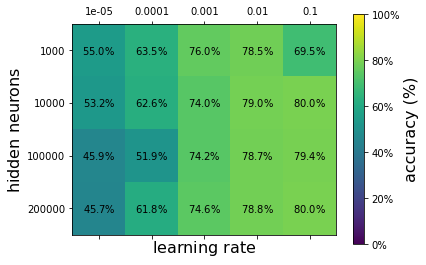

In [8]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# Training settings
parser = argparse.ArgumentParser(description='PyTorch SUSY Example')
parser.add_argument('--dataset_size', type=int, default=100000, metavar='DS',
                help='size of data set (default: 100000)')
parser.add_argument('--high_level_feats', type=bool, default=None, metavar='HLF',
                help='toggles high level features (default: None)')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.05, metavar='LR',
                help='learning rate (default: 0.02)')
parser.add_argument('--momentum', type=float, default=0.8, metavar='M',
                help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                help='disables CUDA training')
parser.add_argument('--seed', type=int, default=2, metavar='S',
                help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                help='how many batches to wait before logging training status')
args = parser.parse_args()

# set seed of random number generator
torch.manual_seed(args.seed)

grid_search(args)


# With CUDA commands

In [162]:
from __future__ import print_function, division
import os,sys
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import torch # pytorch package, allows using GPUs
# fix seed
seed=17
np.random.seed(seed)
from torchvision import datasets # load data

class SUSY_Dataset(torch.utils.data.Dataset):
    """SUSY pytorch dataset."""

    def __init__(self, data_file, root_dir, dataset_size, train=True, transform=None, high_level_feats=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            train (bool, optional): If set to `True` load training data.
            transform (callable, optional): Optional transform to be applied on a sample.
            high_level_festures (bool, optional): If set to `True`, working with high-level features only. 
                                        If set to `False`, working with low-level features only.
                                        Default is `None`: working with all features
        """

        import pandas as pd

        features=['SUSY','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 
                'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

        low_features=['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi']

        high_features=['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']


        #Number of datapoints to work with
        df = pd.read_csv(root_dir+data_file, header=None,nrows=dataset_size,engine='python')
        df.columns=features
        Y = df['SUSY']
        X = df[[col for col in df.columns if col!="SUSY"]]

        # set training and test data size
        train_size=int(0.8*dataset_size)
        self.train=train

        if self.train:
            X=X[:train_size]
            Y=Y[:train_size]
            print("Training on {} examples".format(train_size))
        else:
            X=X[train_size:]
            Y=Y[train_size:]
            print("Testing on {} examples".format(dataset_size-train_size))


        self.root_dir = root_dir
        self.transform = transform

        # make datasets using only the 8 low-level features and 10 high-level features
        if high_level_feats is None:
            self.data=(X.values.astype(np.float32),Y.values.astype(int))
            print("Using both high and low level features")
        elif high_level_feats is True:
            self.data=(X[high_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both high-level features only.")
        elif high_level_feats is False:
            self.data=(X[low_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both low-level features only.")


    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])

        if self.transform:
            sample=self.transform(sample)

        return sample

In [163]:
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

def load_data(args):

    data_file='SUSY.csv'
    root_dir=os.path.expanduser('~')+'/ML_review/SUSY_data/'

    train_kwargs = {} # CUDA arguments, if enabled
    test_kwargs = {}
    

    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    
        
    # load and noralise train and test data
    train_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=True,high_level_feats=args.high_level_feats),
        batch_size=args.batch_size, shuffle=True, **train_kwargs)

    test_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=False,high_level_feats=args.high_level_feats),
        batch_size=args.test_batch_size, shuffle=True, **test_kwargs)
    

    return train_loader, test_loader

In [ ]:
import torch.nn as nn # construct NN

class model(nn.Module):
    def __init__(self,high_level_feats=None):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()

        # an affine operation: y = Wx + b
        if high_level_feats is None:
            self.fc1 = nn.Linear(18, 200) # all features
        elif high_level_feats:
            self.fc1 = nn.Linear(10, 200) # low-level only
        else:
            self.fc1 = nn.Linear(8, 200) # high-level only


        self.batchnorm1=nn.BatchNorm1d(200, eps=1e-05, momentum=0.1)
        self.batchnorm2=nn.BatchNorm1d(100, eps=1e-05, momentum=0.1)

        self.fc2 = nn.Linear(200, 100) # see forward function for dimensions
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        '''Defines the feed-forward function for the NN.

        A backward function is automatically defined using `torch.autograd`

        Parameters
        ----------
        x : autograd.Tensor
            input data

        Returns
        -------
        autograd.Tensor
            output layer of NN

        '''

        # apply rectified linear unit
        x = F.relu(self.fc1(x))
        # apply dropout
        #x=self.batchnorm1(x)
        x = F.dropout(x, training=self.training)


        # apply rectified linear unit
        x = F.relu(self.fc2(x))
        # apply dropout
        #x=self.batchnorm2(x)
        x = F.dropout(x, training=self.training)


        # apply affine operation fc2
        x = self.fc3(x)
        # soft-max layer
        x = F.log_softmax(x,dim=1)

        return x

In [171]:
import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

def evaluate_model(args,device,train_loader,test_loader):

    # create model
    DNN = model(high_level_feats=args.high_level_feats).to(device)
    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    #optimizer = optim.SGD(DNN.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))
    optimizer = optim.Adadelta(DNN.parameters(), lr=args.lr)


    ################################################

    def train(epoch):
        '''Trains a NN using minibatches.

        Parameters
        ----------
        epoch : int
            Training epoch number.

        '''

        # set model to training mode (affects Dropout and BatchNorm)
        DNN.train()
        # loop over training data
        for batch_idx, (data, label) in enumerate(train_loader):
            label = label.type(torch.LongTensor)
            data, label = data.to(device), label.to(device)
            # zero gradient buffers
            optimizer.zero_grad()
            # compute output of final layer: forward step
            output = DNN(data)
            # compute loss
            loss = criterion(output, label)
            # run backprop: backward step
            loss.backward()
            # update weigths of NN
            optimizer.step()
            
            # print loss at current epoch
            if batch_idx % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item() ))
            

        return loss.item()

    ################################################

    def test():
        '''Tests NN performance.

        '''

        # evaluate model
        DNN.eval()

        test_loss = 0 # loss function on test data
        correct = 0 # number of correct predictions
        # loop over test data
        for data, label in test_loader:
            # compute model prediction softmax probability
            label = label.type(torch.LongTensor)
            data, label = data.to(device), label.to(device)
            output = DNN(data)
            # compute test loss
            test_loss += criterion(output, label, size_average=False).item() # sum up batch loss
            # find most likely prediction
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            # update number of correct predictions
            correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()

        # print test loss
        test_loss /= len(test_loader.dataset)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        

        return test_loss, correct / len(test_loader.dataset)


    ################################################


    train_loss=np.zeros((args.epochs,))
    test_loss=np.zeros_like(train_loss)
    test_accuracy=np.zeros_like(train_loss)

    epochs=range(1, args.epochs + 1)
    for epoch in epochs:

        train_loss[epoch-1] = train(epoch)
        test_loss[epoch-1], test_accuracy[epoch-1] = test()



    return test_loss[-1], test_accuracy[-1]

In [172]:
import matplotlib.pyplot as plt

def grid_search(args,device):


    # perform grid search over learnign rate and number of hidden neurons
    dataset_sizes=[1000, 10000, 100000, 200000] #np.logspace(2,5,4).astype('int')
    learning_rates=np.logspace(-5,-1,5)

    # pre-alocate data
    test_loss=np.zeros((len(dataset_sizes),len(learning_rates)),dtype=np.float64)
    test_accuracy=np.zeros_like(test_loss)

    # do grid search
    for i, dataset_size in enumerate(dataset_sizes):
        # upate data set size parameters
        args.dataset_size=dataset_size
        args.batch_size=int(0.01*dataset_size)

        # load data
        train_loader, test_loader = load_data(args)

        for j, lr in enumerate(learning_rates):
            # update learning rate
            args.lr=lr

            print("\n training DNN with %5d data points and SGD lr=%0.6f. \n" %(dataset_size,lr) )

            test_loss[i,j],test_accuracy[i,j] = evaluate_model(args,device,train_loader,test_loader)


    plot_data(learning_rates,dataset_sizes,test_accuracy)
    
def plot_data(x,y,data):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.2,.4,0.6,0.8,1.0])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)

    plt.tight_layout()

    plt.show()

Training on 800 examples
Using both high and low level features
Testing on 200 examples
Using both high and low level features

 training DNN with  1000 data points and SGD lr=0.000010. 

Train Epoch: 1 [0/800 (0%)]	Loss: 0.692516
Train Epoch: 1 [100/800 (12%)]	Loss: 0.815336
Train Epoch: 1 [200/800 (25%)]	Loss: 0.629408
Train Epoch: 1 [300/800 (38%)]	Loss: 0.630682
Train Epoch: 1 [400/800 (50%)]	Loss: 0.741757
Train Epoch: 1 [500/800 (62%)]	Loss: 0.569121
Train Epoch: 1 [600/800 (75%)]	Loss: 0.609522
Train Epoch: 1 [700/800 (88%)]	Loss: 0.683831

Test set: Average loss: 0.6875, Accuracy: 109/200 (54.500%)

Train Epoch: 2 [0/800 (0%)]	Loss: 0.724576
Train Epoch: 2 [100/800 (12%)]	Loss: 0.723515
Train Epoch: 2 [200/800 (25%)]	Loss: 0.654955
Train Epoch: 2 [300/800 (38%)]	Loss: 0.697068
Train Epoch: 2 [400/800 (50%)]	Loss: 0.646270
Train Epoch: 2 [500/800 (62%)]	Loss: 0.726667
Train Epoch: 2 [600/800 (75%)]	Loss: 0.712167
Train Epoch: 2 [700/800 (88%)]	Loss: 0.713593

Test set: Average l


Test set: Average loss: 0.6879, Accuracy: 92/200 (46.000%)

Train Epoch: 10 [0/800 (0%)]	Loss: 0.682911
Train Epoch: 10 [100/800 (12%)]	Loss: 0.748574
Train Epoch: 10 [200/800 (25%)]	Loss: 0.666569
Train Epoch: 10 [300/800 (38%)]	Loss: 0.629050
Train Epoch: 10 [400/800 (50%)]	Loss: 0.795412
Train Epoch: 10 [500/800 (62%)]	Loss: 0.659916
Train Epoch: 10 [600/800 (75%)]	Loss: 0.720371
Train Epoch: 10 [700/800 (88%)]	Loss: 0.779990

Test set: Average loss: 0.6878, Accuracy: 92/200 (46.000%)


 training DNN with  1000 data points and SGD lr=0.001000. 

Train Epoch: 1 [0/800 (0%)]	Loss: 0.731855
Train Epoch: 1 [100/800 (12%)]	Loss: 0.706652
Train Epoch: 1 [200/800 (25%)]	Loss: 0.715261
Train Epoch: 1 [300/800 (38%)]	Loss: 0.677468
Train Epoch: 1 [400/800 (50%)]	Loss: 0.747170
Train Epoch: 1 [500/800 (62%)]	Loss: 0.803334
Train Epoch: 1 [600/800 (75%)]	Loss: 0.750772
Train Epoch: 1 [700/800 (88%)]	Loss: 0.724585

Test set: Average loss: 0.7015, Accuracy: 93/200 (46.500%)

Train Epoch: 2 [0/

Train Epoch: 9 [0/800 (0%)]	Loss: 0.678028
Train Epoch: 9 [100/800 (12%)]	Loss: 0.726746
Train Epoch: 9 [200/800 (25%)]	Loss: 0.667631
Train Epoch: 9 [300/800 (38%)]	Loss: 0.608688
Train Epoch: 9 [400/800 (50%)]	Loss: 0.745255
Train Epoch: 9 [500/800 (62%)]	Loss: 0.654992
Train Epoch: 9 [600/800 (75%)]	Loss: 0.696138
Train Epoch: 9 [700/800 (88%)]	Loss: 0.655125

Test set: Average loss: 0.6744, Accuracy: 129/200 (64.500%)

Train Epoch: 10 [0/800 (0%)]	Loss: 0.755849
Train Epoch: 10 [100/800 (12%)]	Loss: 0.701237
Train Epoch: 10 [200/800 (25%)]	Loss: 0.713928
Train Epoch: 10 [300/800 (38%)]	Loss: 0.653201
Train Epoch: 10 [400/800 (50%)]	Loss: 0.662792
Train Epoch: 10 [500/800 (62%)]	Loss: 0.666790
Train Epoch: 10 [600/800 (75%)]	Loss: 0.676233
Train Epoch: 10 [700/800 (88%)]	Loss: 0.676210

Test set: Average loss: 0.6727, Accuracy: 131/200 (65.500%)


 training DNN with  1000 data points and SGD lr=0.100000. 

Train Epoch: 1 [0/800 (0%)]	Loss: 0.680683
Train Epoch: 1 [100/800 (12%)]	Los

Train Epoch: 7 [4000/8000 (50%)]	Loss: 0.716821
Train Epoch: 7 [5000/8000 (62%)]	Loss: 0.710860
Train Epoch: 7 [6000/8000 (75%)]	Loss: 0.698916
Train Epoch: 7 [7000/8000 (88%)]	Loss: 0.726651

Test set: Average loss: 0.6903, Accuracy: 1040/2000 (52.000%)

Train Epoch: 8 [0/8000 (0%)]	Loss: 0.676209
Train Epoch: 8 [1000/8000 (12%)]	Loss: 0.689678
Train Epoch: 8 [2000/8000 (25%)]	Loss: 0.683373
Train Epoch: 8 [3000/8000 (38%)]	Loss: 0.690861
Train Epoch: 8 [4000/8000 (50%)]	Loss: 0.714092
Train Epoch: 8 [5000/8000 (62%)]	Loss: 0.706744
Train Epoch: 8 [6000/8000 (75%)]	Loss: 0.747382
Train Epoch: 8 [7000/8000 (88%)]	Loss: 0.712664

Test set: Average loss: 0.6903, Accuracy: 1040/2000 (52.000%)

Train Epoch: 9 [0/8000 (0%)]	Loss: 0.694891
Train Epoch: 9 [1000/8000 (12%)]	Loss: 0.690241
Train Epoch: 9 [2000/8000 (25%)]	Loss: 0.712923
Train Epoch: 9 [3000/8000 (38%)]	Loss: 0.751150
Train Epoch: 9 [4000/8000 (50%)]	Loss: 0.683284
Train Epoch: 9 [5000/8000 (62%)]	Loss: 0.709367
Train Epoch: 9 [

Train Epoch: 5 [6000/8000 (75%)]	Loss: 0.687601
Train Epoch: 5 [7000/8000 (88%)]	Loss: 0.718219

Test set: Average loss: 0.6961, Accuracy: 938/2000 (46.900%)

Train Epoch: 6 [0/8000 (0%)]	Loss: 0.698662
Train Epoch: 6 [1000/8000 (12%)]	Loss: 0.693972
Train Epoch: 6 [2000/8000 (25%)]	Loss: 0.726517
Train Epoch: 6 [3000/8000 (38%)]	Loss: 0.702491
Train Epoch: 6 [4000/8000 (50%)]	Loss: 0.718215
Train Epoch: 6 [5000/8000 (62%)]	Loss: 0.700721
Train Epoch: 6 [6000/8000 (75%)]	Loss: 0.702439
Train Epoch: 6 [7000/8000 (88%)]	Loss: 0.697848

Test set: Average loss: 0.6954, Accuracy: 944/2000 (47.200%)

Train Epoch: 7 [0/8000 (0%)]	Loss: 0.721935
Train Epoch: 7 [1000/8000 (12%)]	Loss: 0.709556
Train Epoch: 7 [2000/8000 (25%)]	Loss: 0.713514
Train Epoch: 7 [3000/8000 (38%)]	Loss: 0.716939
Train Epoch: 7 [4000/8000 (50%)]	Loss: 0.716951
Train Epoch: 7 [5000/8000 (62%)]	Loss: 0.702821
Train Epoch: 7 [6000/8000 (75%)]	Loss: 0.713171
Train Epoch: 7 [7000/8000 (88%)]	Loss: 0.677459

Test set: Average


Test set: Average loss: 0.5304, Accuracy: 1543/2000 (77.150%)

Train Epoch: 4 [0/8000 (0%)]	Loss: 0.540840
Train Epoch: 4 [1000/8000 (12%)]	Loss: 0.552635
Train Epoch: 4 [2000/8000 (25%)]	Loss: 0.540234
Train Epoch: 4 [3000/8000 (38%)]	Loss: 0.498889
Train Epoch: 4 [4000/8000 (50%)]	Loss: 0.494978
Train Epoch: 4 [5000/8000 (62%)]	Loss: 0.514219
Train Epoch: 4 [6000/8000 (75%)]	Loss: 0.537834
Train Epoch: 4 [7000/8000 (88%)]	Loss: 0.510296

Test set: Average loss: 0.5018, Accuracy: 1562/2000 (78.100%)

Train Epoch: 5 [0/8000 (0%)]	Loss: 0.596126
Train Epoch: 5 [1000/8000 (12%)]	Loss: 0.498343
Train Epoch: 5 [2000/8000 (25%)]	Loss: 0.582616
Train Epoch: 5 [3000/8000 (38%)]	Loss: 0.519749
Train Epoch: 5 [4000/8000 (50%)]	Loss: 0.564401
Train Epoch: 5 [5000/8000 (62%)]	Loss: 0.469663
Train Epoch: 5 [6000/8000 (75%)]	Loss: 0.591707
Train Epoch: 5 [7000/8000 (88%)]	Loss: 0.607136

Test set: Average loss: 0.4866, Accuracy: 1571/2000 (78.550%)

Train Epoch: 6 [0/8000 (0%)]	Loss: 0.641092
Trai

Train Epoch: 1 [40000/80000 (50%)]	Loss: 0.704347
Train Epoch: 1 [50000/80000 (62%)]	Loss: 0.708498
Train Epoch: 1 [60000/80000 (75%)]	Loss: 0.709413
Train Epoch: 1 [70000/80000 (88%)]	Loss: 0.709752

Test set: Average loss: 0.7006, Accuracy: 9144/20000 (45.720%)

Train Epoch: 2 [0/80000 (0%)]	Loss: 0.700091
Train Epoch: 2 [10000/80000 (12%)]	Loss: 0.706073
Train Epoch: 2 [20000/80000 (25%)]	Loss: 0.703010
Train Epoch: 2 [30000/80000 (38%)]	Loss: 0.700853
Train Epoch: 2 [40000/80000 (50%)]	Loss: 0.709656
Train Epoch: 2 [50000/80000 (62%)]	Loss: 0.707867
Train Epoch: 2 [60000/80000 (75%)]	Loss: 0.710254
Train Epoch: 2 [70000/80000 (88%)]	Loss: 0.705928

Test set: Average loss: 0.7004, Accuracy: 9159/20000 (45.795%)

Train Epoch: 3 [0/80000 (0%)]	Loss: 0.712228
Train Epoch: 3 [10000/80000 (12%)]	Loss: 0.703135
Train Epoch: 3 [20000/80000 (25%)]	Loss: 0.710251
Train Epoch: 3 [30000/80000 (38%)]	Loss: 0.704701
Train Epoch: 3 [40000/80000 (50%)]	Loss: 0.709333
Train Epoch: 3 [50000/80000 (6

Train Epoch: 9 [20000/80000 (25%)]	Loss: 0.686180
Train Epoch: 9 [30000/80000 (38%)]	Loss: 0.692684
Train Epoch: 9 [40000/80000 (50%)]	Loss: 0.686891
Train Epoch: 9 [50000/80000 (62%)]	Loss: 0.693192
Train Epoch: 9 [60000/80000 (75%)]	Loss: 0.688867
Train Epoch: 9 [70000/80000 (88%)]	Loss: 0.687058

Test set: Average loss: 0.6819, Accuracy: 12038/20000 (60.190%)

Train Epoch: 10 [0/80000 (0%)]	Loss: 0.692274
Train Epoch: 10 [10000/80000 (12%)]	Loss: 0.685939
Train Epoch: 10 [20000/80000 (25%)]	Loss: 0.690322
Train Epoch: 10 [30000/80000 (38%)]	Loss: 0.688277
Train Epoch: 10 [40000/80000 (50%)]	Loss: 0.685566
Train Epoch: 10 [50000/80000 (62%)]	Loss: 0.687581
Train Epoch: 10 [60000/80000 (75%)]	Loss: 0.684482
Train Epoch: 10 [70000/80000 (88%)]	Loss: 0.685667

Test set: Average loss: 0.6809, Accuracy: 12189/20000 (60.945%)


 training DNN with 100000 data points and SGD lr=0.010000. 

Train Epoch: 1 [0/80000 (0%)]	Loss: 0.712830
Train Epoch: 1 [10000/80000 (12%)]	Loss: 0.708311
Train Ep


Test set: Average loss: 0.4657, Accuracy: 15711/20000 (78.555%)

Train Epoch: 7 [0/80000 (0%)]	Loss: 0.505939
Train Epoch: 7 [10000/80000 (12%)]	Loss: 0.510497
Train Epoch: 7 [20000/80000 (25%)]	Loss: 0.479187
Train Epoch: 7 [30000/80000 (38%)]	Loss: 0.506719
Train Epoch: 7 [40000/80000 (50%)]	Loss: 0.495853
Train Epoch: 7 [50000/80000 (62%)]	Loss: 0.477682
Train Epoch: 7 [60000/80000 (75%)]	Loss: 0.496334
Train Epoch: 7 [70000/80000 (88%)]	Loss: 0.485189

Test set: Average loss: 0.4614, Accuracy: 15742/20000 (78.710%)

Train Epoch: 8 [0/80000 (0%)]	Loss: 0.486638
Train Epoch: 8 [10000/80000 (12%)]	Loss: 0.489707
Train Epoch: 8 [20000/80000 (25%)]	Loss: 0.485710
Train Epoch: 8 [30000/80000 (38%)]	Loss: 0.492690
Train Epoch: 8 [40000/80000 (50%)]	Loss: 0.487344
Train Epoch: 8 [50000/80000 (62%)]	Loss: 0.506764
Train Epoch: 8 [60000/80000 (75%)]	Loss: 0.505396
Train Epoch: 8 [70000/80000 (88%)]	Loss: 0.491135

Test set: Average loss: 0.4588, Accuracy: 15768/20000 (78.840%)

Train Epoch:

Train Epoch: 3 [140000/160000 (88%)]	Loss: 0.708231

Test set: Average loss: 0.6929, Accuracy: 20646/40000 (51.615%)

Train Epoch: 4 [0/160000 (0%)]	Loss: 0.701039
Train Epoch: 4 [20000/160000 (12%)]	Loss: 0.702912
Train Epoch: 4 [40000/160000 (25%)]	Loss: 0.699184
Train Epoch: 4 [60000/160000 (38%)]	Loss: 0.701397
Train Epoch: 4 [80000/160000 (50%)]	Loss: 0.705772
Train Epoch: 4 [100000/160000 (62%)]	Loss: 0.698006
Train Epoch: 4 [120000/160000 (75%)]	Loss: 0.698487
Train Epoch: 4 [140000/160000 (88%)]	Loss: 0.698631

Test set: Average loss: 0.6927, Accuracy: 20693/40000 (51.733%)

Train Epoch: 5 [0/160000 (0%)]	Loss: 0.697694
Train Epoch: 5 [20000/160000 (12%)]	Loss: 0.696492
Train Epoch: 5 [40000/160000 (25%)]	Loss: 0.695499
Train Epoch: 5 [60000/160000 (38%)]	Loss: 0.701518
Train Epoch: 5 [80000/160000 (50%)]	Loss: 0.703389
Train Epoch: 5 [100000/160000 (62%)]	Loss: 0.703324
Train Epoch: 5 [120000/160000 (75%)]	Loss: 0.699037
Train Epoch: 5 [140000/160000 (88%)]	Loss: 0.701619

Tes

Train Epoch: 1 [20000/160000 (12%)]	Loss: 0.705619
Train Epoch: 1 [40000/160000 (25%)]	Loss: 0.705618
Train Epoch: 1 [60000/160000 (38%)]	Loss: 0.707649
Train Epoch: 1 [80000/160000 (50%)]	Loss: 0.709218
Train Epoch: 1 [100000/160000 (62%)]	Loss: 0.707425
Train Epoch: 1 [120000/160000 (75%)]	Loss: 0.703910
Train Epoch: 1 [140000/160000 (88%)]	Loss: 0.701555

Test set: Average loss: 0.6962, Accuracy: 17759/40000 (44.398%)

Train Epoch: 2 [0/160000 (0%)]	Loss: 0.697859
Train Epoch: 2 [20000/160000 (12%)]	Loss: 0.698020
Train Epoch: 2 [40000/160000 (25%)]	Loss: 0.697657
Train Epoch: 2 [60000/160000 (38%)]	Loss: 0.699592
Train Epoch: 2 [80000/160000 (50%)]	Loss: 0.693503
Train Epoch: 2 [100000/160000 (62%)]	Loss: 0.698475
Train Epoch: 2 [120000/160000 (75%)]	Loss: 0.694010
Train Epoch: 2 [140000/160000 (88%)]	Loss: 0.695836

Test set: Average loss: 0.6887, Accuracy: 22297/40000 (55.742%)

Train Epoch: 3 [0/160000 (0%)]	Loss: 0.691859
Train Epoch: 3 [20000/160000 (12%)]	Loss: 0.692616
Train

Train Epoch: 8 [60000/160000 (38%)]	Loss: 0.499799
Train Epoch: 8 [80000/160000 (50%)]	Loss: 0.479741
Train Epoch: 8 [100000/160000 (62%)]	Loss: 0.495204
Train Epoch: 8 [120000/160000 (75%)]	Loss: 0.485387
Train Epoch: 8 [140000/160000 (88%)]	Loss: 0.478615

Test set: Average loss: 0.4512, Accuracy: 31689/40000 (79.222%)

Train Epoch: 9 [0/160000 (0%)]	Loss: 0.495287
Train Epoch: 9 [20000/160000 (12%)]	Loss: 0.462351
Train Epoch: 9 [40000/160000 (25%)]	Loss: 0.478350
Train Epoch: 9 [60000/160000 (38%)]	Loss: 0.474113
Train Epoch: 9 [80000/160000 (50%)]	Loss: 0.474319
Train Epoch: 9 [100000/160000 (62%)]	Loss: 0.480780
Train Epoch: 9 [120000/160000 (75%)]	Loss: 0.490176
Train Epoch: 9 [140000/160000 (88%)]	Loss: 0.480381

Test set: Average loss: 0.4495, Accuracy: 31709/40000 (79.272%)

Train Epoch: 10 [0/160000 (0%)]	Loss: 0.466986
Train Epoch: 10 [20000/160000 (12%)]	Loss: 0.477124
Train Epoch: 10 [40000/160000 (25%)]	Loss: 0.503551
Train Epoch: 10 [60000/160000 (38%)]	Loss: 0.458490
T

<ipython-input-172-81cc7ecb0d73>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+x)
<ipython-input-172-81cc7ecb0d73>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+y)


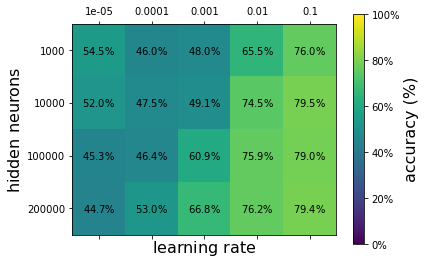

In [173]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# Training settings
parser = argparse.ArgumentParser(description='PyTorch SUSY Example')
parser.add_argument('--dataset_size', type=int, default=100000, metavar='DS',
                help='size of data set (default: 100000)')
parser.add_argument('--high_level_feats', type=bool, default=None, metavar='HLF',
                help='toggles high level features (default: None)')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.05, metavar='LR',
                help='learning rate (default: 0.02)')
parser.add_argument('--momentum', type=float, default=0.8, metavar='M',
                help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                help='disables CUDA training')
parser.add_argument('--seed', type=int, default=2, metavar='S',
                help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                help='how many batches to wait before logging training status')
args = parser.parse_args()

# set seed of random number generator and put the CUDA commands back into the code
use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

grid_search(args,device)


## Exercises

* One of the advantages of Pytorch is that it allows to automatically use the CUDA library for fast performance on GPU's. For the sake of clarity, we have omitted this in the above notebook. Go online to check how to put the CUDA commands back into the code above. _Hint:_ study the [Pytorch MNIST tutorial](https://github.com/pytorch/examples/blob/master/mnist/main.py) to see how this works in practice.


# Answer:

I have google several times for fixing the error of ‘expected scalar type Long but found Int’. Most of them told me that I need to set my data into longer type tensor, which is an integer using 64 bits. I guess we are having 32 bits in our code. 
However, I do not know where to add data = data.type(torch.LongTensor). After I have asked Glen, he told me add  label = label.type(torch.LongTensor) inside two for loops. I have also reintalled mkl and
"import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'" (because Tensorflow GPU isn't supported) Then I could finally run the code and obtain the plot.

For  lr = $10^{-5}$, the number of hidden neurons' layers has no much effect when(The accuracy barely changed). Increase the number of data points would decrease the accuracy.<br>
For lr = 0.0001, the number of data points has no much effect when(The accuracy barely changed). But increase the hidden neuron layers would increase the accuracy. <br>
For lr = 0.001, increase the number of data point has no many changes in this section, but more layers of neuron may help.<br>
For lr = 0.01, 1000 data points is good enough predict the data. <br>
For lr = 0.1, we need to have at least 10000 data points to in order to obtain a good result. 

## CUDA

After study the [Pytorch MNIST tutorial](https://github.com/pytorch/examples/blob/master/mnist/main.py), I add the following three lines of code and add "$\bf{.to(device)}$" to data, label, and model.  Also changing the optimizer to "$\bf{optim.Adadelta(DNN.parameters(), lr=args.lr)}$"

In [174]:
use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

For  lr = $10^{-5}$, the number of hidden neurons' layers has no much effect when(The accuracy barely changed). Increase the number of data points would decrease the accuracy.<br>
For lr = 0.0001, increase the number of data points increase the accuracy barely. But increase the hidden neuron layers would increase the accuracy. <br>
For lr = 0.001, increase the number of data point has no much changes in this section, but more layers of neuron may help.<br>
For lr = 0.01, Increase both number of data and number of neuron layers would increase the accuracy of performance. . <br>
For lr = 0.1, after 10000 data point there is no much changes, but increase number of neuron layers would increase the accuracy of performance. 

Overall, the CUDA commands perform worse than the original code (maybe my GPU is bad I don't know). Also, increase the number of data points would increase the accuracy of performance (expect when lr = $10^{-5}$). 

In [ ]:
ADR: 2/2